### Run only on Colab

In [1]:
! pip install transformers datasets pytorch_metric_learning faiss-gpu umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! wget https://raw.githubusercontent.com/drchapman-17/LyricStyleSpace/main/data.json

--2023-03-14 14:11:40--  https://raw.githubusercontent.com/drchapman-17/LyricStyleSpace/main/data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21129622 (20M) [text/plain]
Saving to: ‘data.json.1’

data.json.1         100%[===================>]  20.15M  --.-KB/s    in 0.07s   

2023-03-14 14:11:41 (305 MB/s) - ‘data.json.1’ saved [21129622/21129622]



## Preliminary Steps

In [3]:
from datasets import load_dataset
import numpy as np
import re
from matplotlib import pyplot as plt



dataset = load_dataset('json',data_files='data.json').class_encode_column('artist')
artists_mappings = dataset['train'].features['artist'].names

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-cef28357b579bb5e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Casting to class labels:   0%|          | 0/7185 [00:00<?, ? examples/s]

In [4]:
def clean(example):
    allowed_parts = ['verse','break','chorus','intro', 'interlude', 'bridge', 'outro']
    for part in allowed_parts:
        example['lyrics']=re.sub("\[.*"+part+".*\]", f"[{part}]", example['lyrics'], flags=re.IGNORECASE)
    example['lyrics']=re.sub("\[(?!"+"|".join(allowed_parts)+").*?\]", "", example['lyrics'], flags=re.DOTALL)
    example['lyrics']=re.sub("[0-9]+embed", "", example['lyrics'], flags=re.IGNORECASE)
    return example

mapped_dataset = dataset.map(clean)


Map:   0%|          | 0/7185 [00:00<?, ? examples/s]

In [5]:
def list_song_parts(example):
    parts = re.findall(r'\[[^\[\]]+\]',example['lyrics']) # Capture everything enclosed in square brackets
    for i,part in enumerate(parts): 
        parts[i] = re.sub(r':.*(?=\])','',part) # Remove everything from : to the closing bracket ] (Most lyrics contain the name of the singer of these parts e.g. [Chorus: 2 Chainz])
    return {'parts': parts}
parts = mapped_dataset['train'].map(list_song_parts,remove_columns=dataset['train'].column_names)

parts:np.ndarray = np.unique([el for l in parts['parts'] for el in l ])

Map:   0%|          | 0/7185 [00:00<?, ? examples/s]

In [6]:
print(*parts)

[break] [bridge] [chorus] [interlude] [intro] [outro] [verse]


In [7]:
# print(mapped_dataset)
print(dataset['train'][1000]['lyrics'])
print("----------------")
print(mapped_dataset['train'][1000]['lyrics'])

XO TOUR Llif3 Lyrics[Intro]
Are you alright?
I'm alright, I'm quite alright
And my money's right
8… (Yeah)
Countin' them bands
All way to the top 'til they be fallin' over
(Yeah, yeah, yeah)
Countin' them bands
On my way to the top 'til we fallin' over

[Chorus]
I don't really care if you cry
On the real, you shoulda never lied
Shoulda saw the way she looked me in my eyes
She said, "Baby, I am not afraid to die"
Push me to the edge
All my friends are dead
Push me to the edge
All my friends are dead
Push me to the edge
All my friends are dead
Push me to the edge

[Verse 1]
Phantom that's all red, inside all white
Like somethin' you ride a sled down, I just want that head
My Brittany got mad, I'm barely her man now
Everybody got the same swag now
Watch the way that I tear it down
Stackin' my bands all the way to the top
All the way 'til my bands fallin' over
Every time that you leave your spot
Your girlfriend call me like, "Come on over!"
I like the way that she treat me
Gon' leave you, 

In [8]:
allowed_parts = ['verse','break','chorus','intro', 'interlude', 'bridge', 'outro']
def contains_one_of(allowed_parts,part:str):
    for p in allowed_parts:
        if p in part.lower(): return True
    return False
filtered_parts = np.unique([part for part in parts if contains_one_of(allowed_parts,part)])

In [9]:
sorted(filtered_parts)

['[break]',
 '[bridge]',
 '[chorus]',
 '[interlude]',
 '[intro]',
 '[outro]',
 '[verse]']

# Preprocessing

In [10]:
def plot_dist(dataset):
    counts = {}
    for example in dataset:
        if example['artist'] not in counts.keys():
            counts[example['artist']] = 0
        else:
            counts[example['artist']] += 1
    plt.bar(counts.keys(), counts.values())

## Train Test Val Split

In [11]:
from datasets import DatasetDict
tts_mapped_dataset = mapped_dataset['train'].train_test_split(train_size=0.7)
mapped_dataset_valid = tts_mapped_dataset['test'].train_test_split(train_size=0.3)

train_test_val_dataset = DatasetDict({
    'train': tts_mapped_dataset['train'],
    'test':mapped_dataset_valid['test'],
    'val': mapped_dataset_valid['train']
    
})
train_test_val_dataset_filtered = train_test_val_dataset.filter(lambda example: example["artist"]<10)
train_test_val_dataset_filtered

Filter:   0%|          | 0/5029 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1510 [00:00<?, ? examples/s]

Filter:   0%|          | 0/646 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['artist', 'lyrics'],
        num_rows: 714
    })
    test: Dataset({
        features: ['artist', 'lyrics'],
        num_rows: 209
    })
    val: Dataset({
        features: ['artist', 'lyrics'],
        num_rows: 77
    })
})

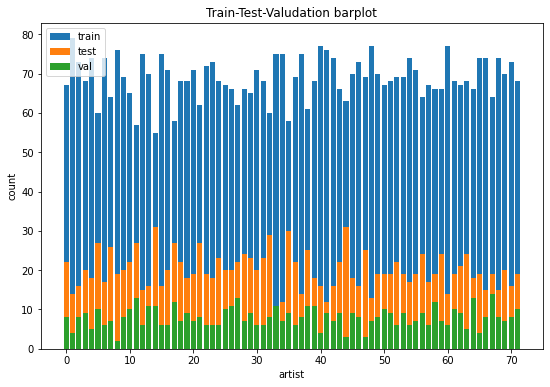

In [12]:
plt.figure(figsize=(9,6))
plt.title("Train-Test-Valudation barplot")
plt.ylabel("count")
plt.xlabel("artist")
plot_dist(train_test_val_dataset['train'])
plot_dist(train_test_val_dataset['test'])
plot_dist(train_test_val_dataset['val'])
plt.legend(['train', 'test', 'val'])
plt.show()

# Machine Learning

In [13]:
from transformers import AutoModel, AutoTokenizer

# Language Model Declaration:

modelckpt="bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(modelckpt)

In [14]:
# Tokenize
def prepare_train_features(examples):
    tokenized_examples = tokenizer(
        examples['lyrics'],
        truncation=True,
        padding=True,
        max_length=512
        )
    tokenized_examples['labels'] = examples['artist']
    return tokenized_examples

# train_features = train_test_val_dataset['train'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["train"].column_names).with_format('torch')
# test_features = train_test_val_dataset['test'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["test"].column_names).with_format('torch')
# val_features = train_test_val_dataset['val'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["val"].column_names).with_format('torch')

train_features = train_test_val_dataset_filtered['train'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["train"].column_names).with_format('torch')
test_features = train_test_val_dataset_filtered['test'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["test"].column_names).with_format('torch')
val_features = train_test_val_dataset_filtered['val'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["val"].column_names).with_format('torch')

Map:   0%|          | 0/714 [00:00<?, ? examples/s]

Map:   0%|          | 0/209 [00:00<?, ? examples/s]

Map:   0%|          | 0/77 [00:00<?, ? examples/s]

In [46]:
from cycler import cycler
from prettytable import PrettyTable

def summary(model):
    table = PrettyTable(["Modules", "Parameters","Trainable"])
    table.align["Modules"] = "l"
    total_params = 0
    total_trainable = 0
    for name, parameter in model.named_parameters():
        params = parameter.numel()
        
        if parameter.requires_grad:
          trainable = 'Yes'
          total_trainable += params
        else: 
          trainable = 'No'
        table.add_row([name, params,trainable])
    
        total_params+=params
    print(table)
    print(f"Total Params: {total_params} (Trainable: {total_trainable})")

def visualize_embeddings(embeddings, labels,label_mappings):
  label_set = np.unique(labels)
  num_classes = len(label_set)
  plt.figure(figsize=(20,15))
  plt.gca().set_prop_cycle(
      cycler(
          "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0,0.9, num_classes)]
      )
  )

  for i in range(num_classes):
    idx = (labels==label_set[i])
    plt.plot(embeddings[idx,0], embeddings[idx,1], ".", markersize=10, label=label_mappings[label_set[i]])
    plt.legend(loc="best", markerscale=1)
  plt.show()
  # plt.figure()
  # for i in range(num_classes):
  #   plt.plot(0, i, ".", markersize=10, label=i)
  #   plt.text(0.01,label_set[i],label_mappings[label_set[i]])
  # plt.show()

In [56]:
import torch
import umap
from tqdm import tqdm
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from typing import Tuple

device = 'cpu'
if torch.cuda.is_available():
    device='cuda'

class TransformerModel(torch.nn.Module):
    def __init__(self, 
                 model_name : str, 
                 hidden_dims : Tuple[int] = (128,)):
        super(TransformerModel, self).__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.dense_layers = torch.nn.ModuleList()
        last_hidden_size = self.transformer.config.hidden_size
        for dim in hidden_dims: 
          self.dense_layers.append(torch.nn.Linear(last_hidden_size, dim))
          last_hidden_size = dim

    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(input_ids, attention_mask)
        out = outputs["pooler_output"] 
        for layer in self.dense_layers:
          out = torch.nn.functional.relu(out)
          out = layer(out)
        return out

def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    # Train your model
    for batch_idx,batch in enumerate(tqdm(train_loader)):
        # Extract the input ids and attention masks from the batch
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Encode the inputs using the pre-trained model
        embeddings = model(input_ids=input_ids, attention_mask=attention_mask)
        # print(embeddings)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                "Epoch {} Iteration {}:  Number of mined triplets = {}".format(
                    epoch, batch_idx, mining_func.num_triplets
                )
            )

    # Print the loss every epoch
    print('Epoch [{}/{}], Loss: {}'.format(epoch, epochs, loss.item()))

def get_all_embeddings(dataloader, model):
  model.eval()
  embeddings, labels = [], []
  with torch.no_grad():
    for idx, batch in enumerate(tqdm(dataloader)):
      input_ids, attention_mask, label = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
      embeddings.append(model(input_ids=input_ids, attention_mask=attention_mask))
      labels.append(label)

  return torch.vstack(embeddings), torch.cat(labels)

def test(train_loader, test_loader, model, accuracy_calculator):
  train_embeddings, train_labels = get_all_embeddings(train_loader, model)
  test_embeddings, test_labels = get_all_embeddings(test_loader, model)
  accuracies = accuracy_calculator.get_accuracy(test_embeddings, test_labels, train_embeddings, train_labels)

  print(f"Test set accuracy (Precision@1) = {accuracies['precision_at_1']}")

In [70]:
# Load pretrained model
model = TransformerModel(modelckpt,hidden_dims=(128,16,2))
model = model.to(device)
summary(model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


+----------------------------------------------------------------+------------+-----------+
| Modules                                                        | Parameters | Trainable |
+----------------------------------------------------------------+------------+-----------+
| transformer.embeddings.word_embeddings.weight                  |  23440896  |    Yes    |
| transformer.embeddings.position_embeddings.weight              |   393216   |    Yes    |
| transformer.embeddings.token_type_embeddings.weight            |    1536    |    Yes    |
| transformer.embeddings.LayerNorm.weight                        |    768     |    Yes    |
| transformer.embeddings.LayerNorm.bias                          |    768     |    Yes    |
| transformer.encoder.layer.0.attention.self.query.weight        |   589824   |    Yes    |
| transformer.encoder.layer.0.attention.self.query.bias          |    768     |    Yes    |
| transformer.encoder.layer.0.attention.self.key.weight          |   589824   | 

100%|██████████| 14/14 [00:06<00:00,  2.20it/s]


TypeError: ignored

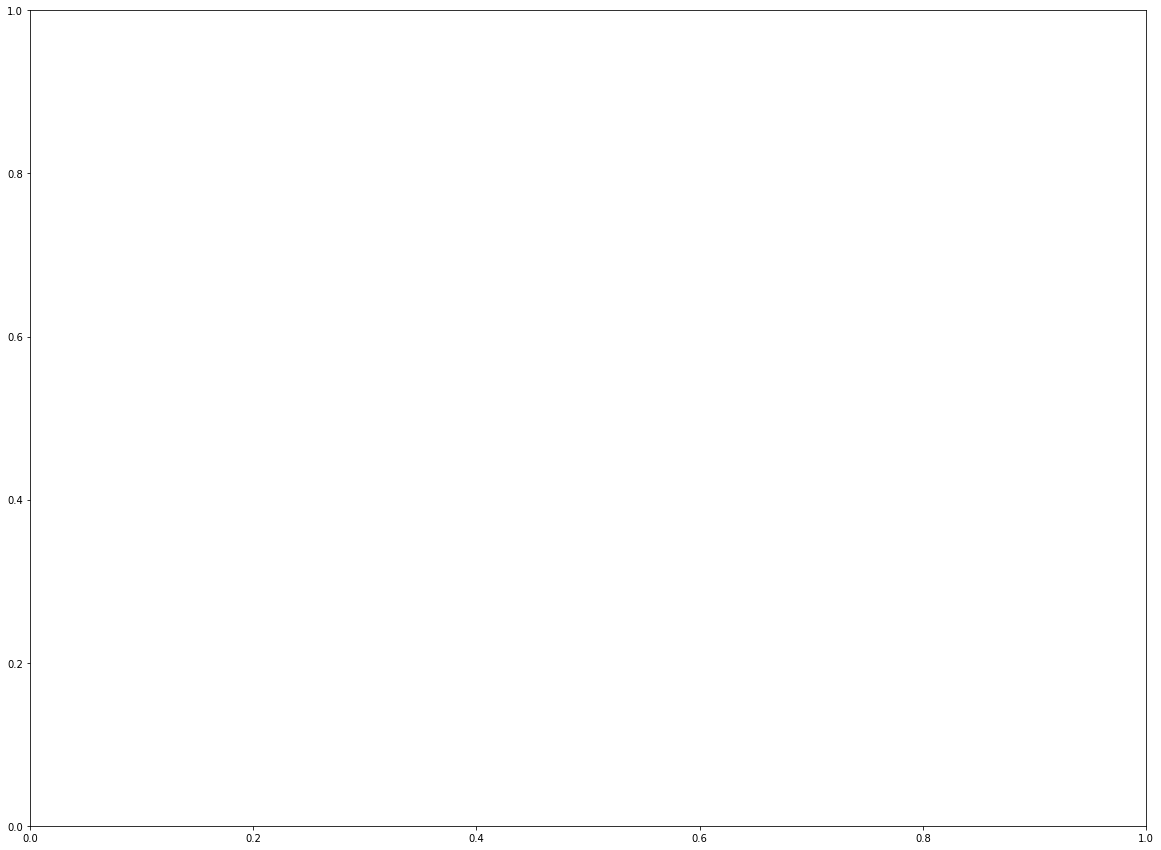

In [75]:
# visualize the embeddings before the training
umap_visualizer = umap.UMAP()
embeddings, labels = get_all_embeddings(test_loader, model)
embeddings_reduced = umap_visualizer.fit_transform(embeddings.cpu().numpy())
visualize_embeddings(embeddings.cpu().numpy(), labels.cpu().numpy(),artists_mappings)

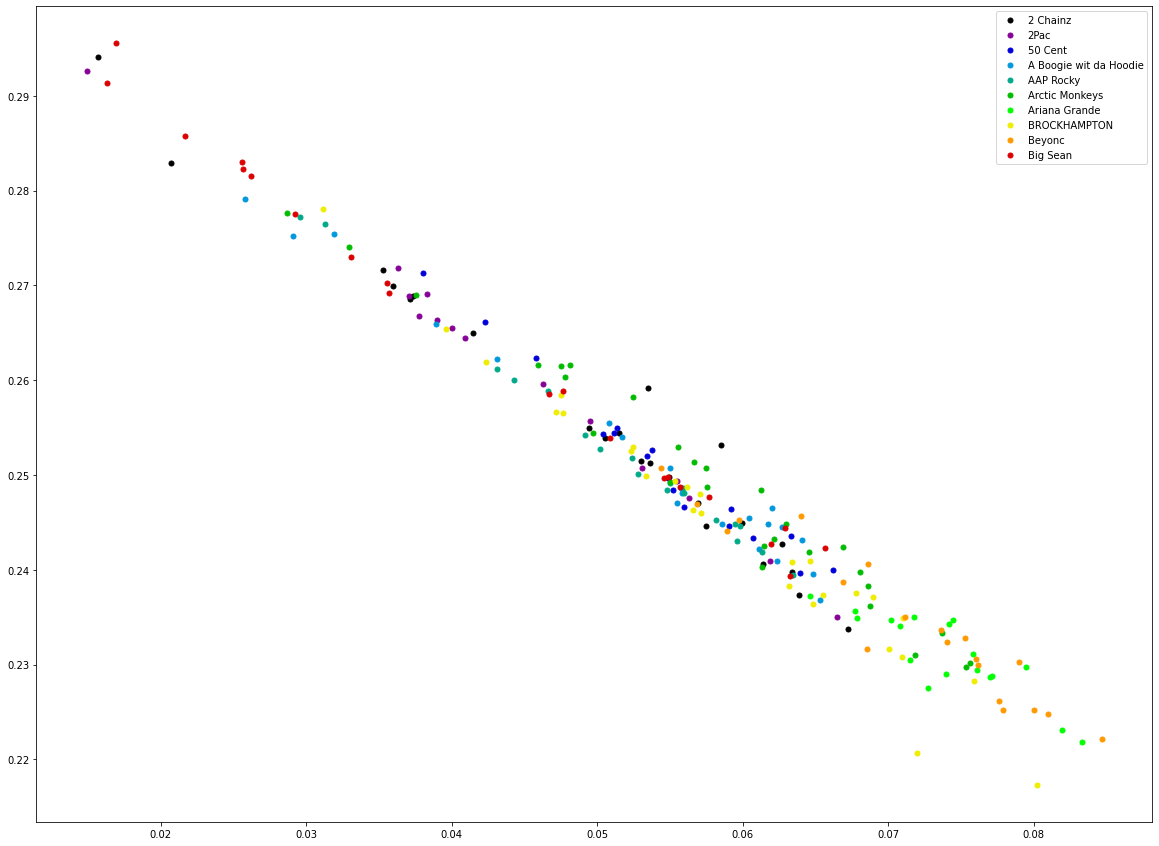

In [76]:
embeddings, labels = get_all_embeddings(test_loader, model)
visualize_embeddings(embeddings.cpu().numpy(), labels.cpu().numpy(),artists_mappings)


In [78]:
# Define training hyperparameters
learning_rate = 1e-5
epochs = 5
batch_size = 16

# Define your training data
train_loader = DataLoader(train_features,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_features,batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_features,batch_size=batch_size, shuffle=True)

# Define your optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
margin = 0.1


loss_func = losses.TripletMarginLoss(margin=margin, smooth_loss=True,) # triplet loss with margin 0.1
mining_func = miners.TripletMarginMiner(margin=margin, type_of_triplets="semihard") # use semihard mining
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1, device=torch.device('cpu'))

for epoch in range(1, epochs + 1):
    train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)

  0%|          | 0/45 [00:00<?, ?it/s]


OutOfMemoryError: ignored

In [ ]:
test(train_loader, test_loader, model, accuracy_calculator)

In [ ]:
umap_visualizer = umap.UMAP(metric='euclidean')
embeddings, labels = get_all_embeddings(test_loader, model)
embeddings_reduced = umap_visualizer.fit_transform(embeddings.cpu().numpy())
visualize_embeddings(embeddings_reduced, labels.cpu().numpy(),artists_mappings)

100%|██████████| 45/45 [00:19<00:00,  2.29it/s]


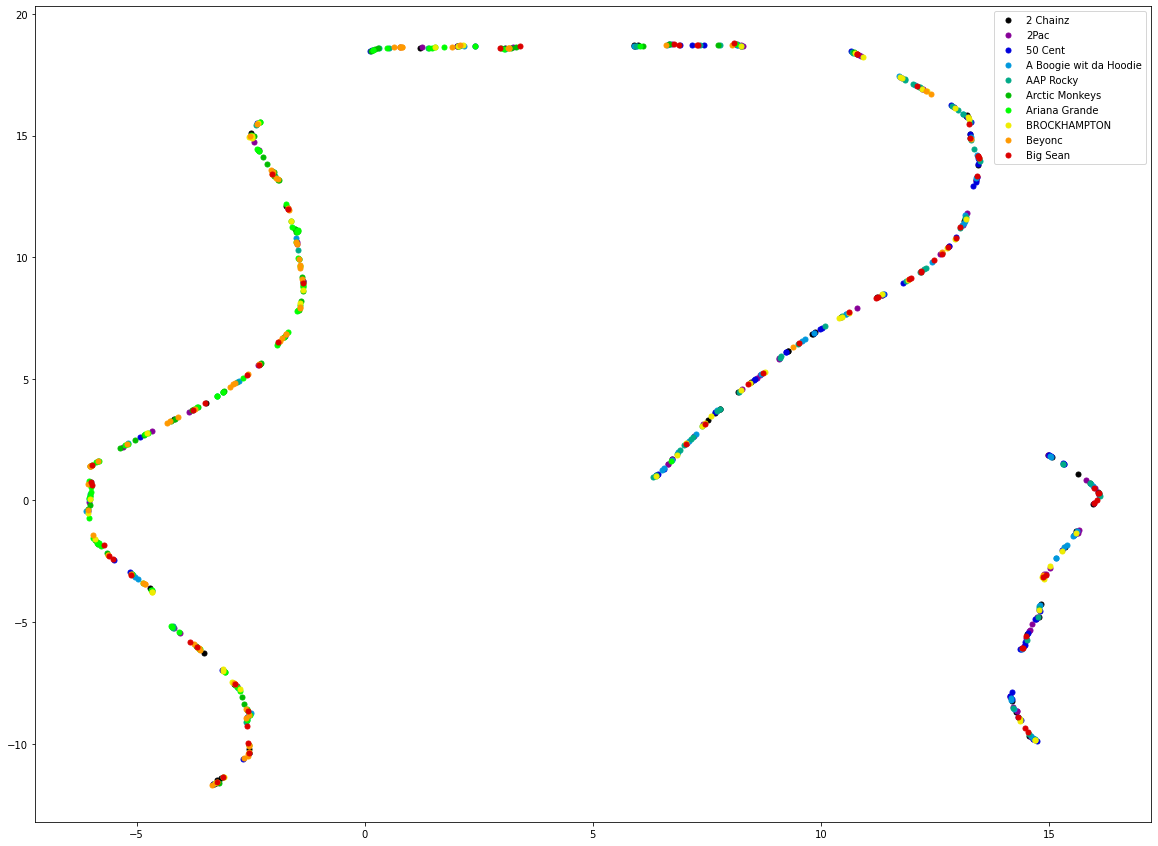

In [69]:
embeddings, labels = get_all_embeddings(test_loader, model)
visualize_embeddings(embeddings.cpu().numpy(), labels.cpu().numpy(),artists_mappings)